In [1]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
import requests
from bs4 import BeautifulSoup

#look for particular tags to get the reviews
def saveReviews(rev,soup):
    revs=soup.find_all("div",{"class":"spaceit textReadability word-break pt8 mt8",
                     "style":"clear: both; border-top: 1px solid #ebebeb;"})
    if len(revs)>1:
        for i in range(len(revs)):
            single_rev=revs[i].getText().strip().replace("\n","")[80:580]
            rev.write(single_rev+"\n")

In [ ]:
#Save the reviews
for page in tqdm(range(0,382)):

    start=50*page

    for i in range(start,start+50):
        #Open the articles of the page and save all the revies in a single directory
        os.chdir("Page"+str(page+1))
        art=open("article"+str(i+1)+'.html',"r")
        os.chdir("..")
        os.chdir("Reviews")
        rev=open("review_"+str(i+1)+".txt","w")

        soup=BeautifulSoup(art.read(), "html.parser") 

        #Just use the saving function we developed earlier
        saveReviews(rev,soup)

        art.close()
        rev.close()
        os.chdir("..")


In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import *
from nltk.corpus import stopwords
nltk.download('stopwords')

In [ ]:
#Function that applies tokenize,lower,removes stopwords and stemming to a given string
def clean(string):
    tokenizer = RegexpTokenizer(r'\w+')
    string=tokenizer.tokenize(string)
    for word in range(len(string)):
        string[word] = string[word].lower() 
    #Remove stopwords
    string = [word for word in string if not word in stopwords.words()]
    #STEMMING
    stemmer = PorterStemmer()
    string = [stemmer.stem(word) for word in string]
    return str(" ".join(string))

In [ ]:
#
art_comment=[]
os.chdir("Reviews")
comments=[]
art_comment=[]
for page in tqdm(range(0,19083)):
    if os.stat("review_"+str(page+1)+".txt").st_size != 0: #do all the stuff below if the file is bigger than 0 bytes,
                                                           #so just do it if it's not empty
        rev=open("review_"+str(page+1)+".txt","r")
        lines=rev.readlines()
        for i in range(len(lines)):
            art_comment.append(clean(lines[i]))
        comments.append(str(art_comment)+"\n")            #we are saving as a list of lists the "cleaned" comments for 
                                                          #every page like so
                                                          #[[comment1page1,comment2page1,..][comment1page2,..]...]
        art_comment=[]
        rev.close()
    else:
        comments.append("\t\n")
    
os.chdir("..")

In [ ]:
#save results
os.chdir("Reviews")
c=open("comments.txt","w")
for comment in comments:
    c.write(str(comment))
c.close()
os.chdir("..")

In [2]:
#load results
comments=[]
c=open("comments.txt","r")
lines=c.readlines()
for i in range(len(lines)):
    comments.append(lines[i].replace("\n","").replace("[","").replace("]","").replace("'",'').split(","))
c.close()

In [3]:
len(comments)

19083

In [4]:
#build corpus with the single words appearing in all reviews
corpus={}
#update=1
for i in tqdm(range(len(comments))):
    #print("i={}".format(i))
    for j in range(len(comments[i])):
        sentence=comments[i][j].split(" ")
        
        for word in sentence:
            
            if word not in corpus:
                corpus.update({word:0})
                #update=update+1
                

100%|██████████| 19083/19083 [00:00<00:00, 87146.81it/s]


In [5]:
len(corpus)

36595

In [6]:
#build vector with the count of words appearing in all reviews
vectors=[]
vec_sentence=[]
doc=dict.fromkeys(corpus, 0)
for i in tqdm(range(0,len(comments))):
    vec_sentence=[]
    for j in range(len(comments[i])):
        
        sentence=comments[i][j].split(" ")
        for word in sentence:
            doc[word] += 1
        
        vec_sentence.append(list(doc.values()))
        doc=dict.fromkeys(corpus, 0)
    vectors.append(vec_sentence)
    

100%|██████████| 19083/19083 [01:18<00:00, 241.71it/s]


In [7]:
print(len(corpus))
print(len(comments[:][:]))
len(vectors)

36595
19083


19083

In [16]:
import matplotlib.pyplot as plt
#from kneed import KneeLocator
from sklearn.cluster import KMeans
import numpy as np

In [9]:
X=[]
for i in range(len(vectors)):
    for j in range(len(vectors[i])):
        X.append(vectors[i][j])
X=np.array(X)

In [10]:
def release_list(a):
    del a[:]
    del a

In [11]:
release_list(vectors)

In [39]:
kmeans = KMeans(init="random", n_clusters=2, n_init=30, max_iter=5000).fit(X)

In [40]:
(kmeans.labels_)

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

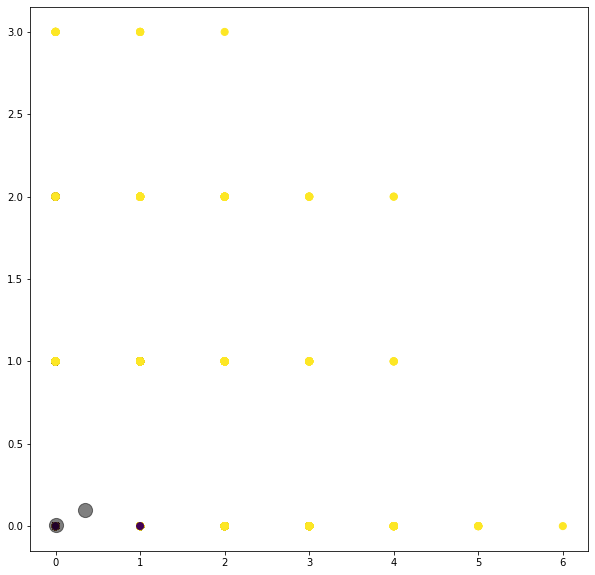

In [41]:
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

In [35]:
len(X[0])

36595

We are applying KMeans (k=2) to vectors belonging to $R^{36595}$. The results of the clustering clearly show that most of the data is put into a single label while the cluster centers seem to be in need of more iterations to get to decent positions (since the deadline is very close we have no time to do that). \
Probably a better way to solve the problem would be implementing a neural network, but it would take a lot of time to assign the labels to the comments (those are needed for the training). Or maybe it could also work to train the neural network with the results obtained from the clustering, but we can't estimate how accurate the KMeans is.